# 0.Assignments

👾 這個陽春的聊天機器人需要被優化！<br>
若是一個對話串不間斷地持續進行，送進去的訊息量會很多，tokens數量也會跟著增加，會需要花比較多費用(💸💸💸)，也可能使模型的回應雜訊比較多而回應受到干擾，所以我們可以優化短期記憶。<br>
另外，我們希望優化使用者體驗，我們可以根據聊天的內容整理出使用者的屬性，並在每一次跟使用者聊天時，都能根據這個使用者的狀況給予客製化的回應，因此我們要加入長期記憶的功能！

<br>

### 1. 短期記憶優化

(1) 🔰 [基本版] 在短期記憶中，將chatbot node送入llm的訊息中加入trim的優化機制 (依據適當的tokens數量決定)


<br>

### 2. 加入長期記憶

加入長期記憶，讓聊天機器人能夠記住使用者的資訊（名字、偏好語言、興趣），在下一次對話也能針對同個使用者的資訊，給予個人化的回答。

(1) 🔰 [基本版]
- chatbot node: 在chatbot node中，將該使用者的資訊取出，讓入prompt中讓llm依據使用者的資訊給予個人化的回答

- write_memory node: 在每一次生成回答後，將使用者的資訊整理成一段對使用者的描述(使用llm，給予system prompt做指引，自行設計如何整理、需要整理哪些資訊)，將整理完的資訊整理到store (可跨threads存取的地方)。

- config: config從原本的短期記憶只有thread_id, 也要加入user_id

<img src="https://drive.google.com/uc?export=view&id=1H4Y0WplOi6R4Eo06Ac2JA_9TbZa2YaRD" width="100"/>


(2) 👨‍🎓 [進階版]
- chatbot node: 可以決定使用者的問題是否需要從長期記憶中取得資訊，以及需要取得什麼資訊
- write_memory node: 可以整理成特定格式 (例如：使用with_structured_output，相關概念可以延伸到R3 tool calling內容)。例如：
```
user_profile = {
  "first_name": "XXXX",
  "last_name": "OOO",
  "preferred_lang": ["en", "zh-tw"]
}
```
- 也可以自行將graph結構調整自己喜歡的(增刪不同node, conditional router, ...)
<br>
備註：基本版是需要大家完成的，進階版可以自行決定是否挑戰，Enjoy the ride! 😎

# 1.短期記憶

## (1) 基本版
🔰 [基本版] 在短期記憶中，將chatbot node送入llm的訊息中加入trim的優化機制 (依據適當的tokens數量決定)

note: 可以邊做邊看一下trim設定的效果以及內部運作的機制

In [7]:
%%capture --no-stderr
!pip install -U langgraph langchain_openai==0.3.15 langchain transformers bitsandbytes langchain-huggingface langchain_core pydantic

In [15]:
import os
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore
from langchain_openai import ChatOpenAI
from langchain_core.messages import trim_messages

In [16]:
# 替代的 token 計算方法
def count_tokens_approximately(messages):
    """簡單的 token 估算函數"""
    total = 0
    for message in messages:
        if hasattr(message, 'content'):
            # 粗略估算：英文約 4 字元 = 1 token，中文約 1 字 = 1 token
            content = str(message.content)
            # 簡單估算：每 3.5 個字元約等於 1 token
            total += len(content) // 3
    return total

In [17]:
os.environ['OPENAI_API_KEY'] = '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'
os.environ['OPENAI_API_BASE'] = 'https://openrouter.ai/api/v1'

In [113]:
llm = ChatOpenAI(
    model="qwen/qwen3-14b:free",  # 可以選擇其他模型
    temperature=0.7,
    max_tokens=3000
)

In [54]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

def chatbot_basic(state: State):
    """基本版聊天機器人，包含訊息修剪功能"""
    messages = state["messages"]

    try:
        trimmed_messages = trim_messages(
            messages,
            max_tokens=2000,
            strategy="last",
            token_counter=count_tokens_approximately,
            include_system=True
        )
    except Exception as e:
        print(f"Trim messages 失敗，使用備用方案: {e}")
        trimmed_messages = messages[-10:]

    response = llm.invoke(trimmed_messages)
    return {"messages": [response]}

In [55]:
def create_basic_graph():
    """建立基本版 graph"""
    graph_builder = StateGraph(State)
    graph_builder.add_node("chatbot", chatbot_basic)
    graph_builder.add_edge(START, "chatbot")
    graph_builder.add_edge("chatbot", END)

    memory = MemorySaver()
    graph = graph_builder.compile(checkpointer=memory)
    return graph

# 2.長期記憶

## (1) 基本版
🔰 [基本版]
- chatbot node: 在chatbot node中，將該使用者的資訊取出，讓入prompt中讓llm依據使用者的資訊給予個人化的回答

- write_memory node: 在每一次生成回答後，將使用者的資訊整理成一段對使用者的描述(使用llm，給予system prompt做指引，自行設計如何整理、需要整理哪些資訊)，將整理完的資訊整理到store (可跨threads存取的地方)。

- config: config從原本的短期記憶只有thread_id, 也要加入user_id

<img src="https://drive.google.com/uc?export=view&id=1H4Y0WplOi6R4Eo06Ac2JA_9TbZa2YaRD" width="100"/>

In [103]:
def chatbot_with_memory(state: State, *, config):
    """包含長期記憶的聊天機器人"""
    messages = state["messages"]

    # Debug: 輸出 config 資訊
    print(f"=== Chatbot Config Debug ===")
    print(f"Config type: {type(config)}")
    print(f"Config content: {config}")

    # 從 config 取得 user_id
    user_id = config["configurable"]["user_id"]
    print(f"User ID: {user_id}")

    # 嘗試獲取 store - 修正版
    store = None

    # 方法1: 直接從 config 取得
    if hasattr(config, 'store'):
        store = config.store
        print("Store 來源: config.store")
    elif 'store' in config:
        store = config['store']
        print("Store 來源: config['store']")

    # 方法2: 從 configurable 中取得
    elif 'store' in config.get('configurable', {}):
        store = config['configurable']['store']
        print("Store 來源: config['configurable']['store']")

    # 方法3: 使用全域變數
    else:
        global global_store
        store = global_store
        print("Store 來源: global_store")

    print(f"Store 狀態: {store is not None}")

    # 從 store 取得使用者的長期記憶 - 修正版
    user_memory = None
    if store:
        try:
            namespace = ("user_profiles", user_id)
            print(f"嘗試讀取 namespace: {namespace}")

            # 修正：使用 get 方法而不是 search
            memory_item = store.get(namespace, "profile")
            if memory_item:
                user_memory = memory_item.value
                print(f"✅ 找到使用者記憶: {user_memory[:100]}...")
            else:
                print("❌ 沒有找到使用者記憶")

            # 額外調試：也試試 search 方法
            try:
                memories = list(store.search(namespace))
                print(f"Search 結果數量: {len(memories)}")
                for i, mem in enumerate(memories):
                    print(f"  Memory {i}: {str(mem)[:100]}...")
            except Exception as search_e:
                print(f"Search 方法錯誤: {search_e}")

        except Exception as e:
            print(f"讀取長期記憶錯誤: {e}")
            import traceback
            traceback.print_exc()
    else:
        print("⚠️  無法獲取 store")

    # 準備系統提示詞
    system_prompt = "你是一個友善的聊天機器人助手，請用繁體中文回應。"

    if user_memory:
        system_prompt += f"\n\n關於這個使用者的資訊：{user_memory}\n請根據使用者的資訊給予個人化的回應。"
        print("✅ 已加入個人化資訊到系統提示中")
    else:
        print("❌ 沒有個人化資訊可用")

    # 構建完整的訊息列表
    full_messages = [SystemMessage(content=system_prompt)]

    # 修剪歷史訊息
    try:
        trimmed_messages = trim_messages(
            messages,
            max_tokens=1500,
            strategy="last",
            token_counter=count_tokens_approximately,
            include_system=False
        )
    except Exception as e:
        trimmed_messages = messages[-8:]

    full_messages.extend(trimmed_messages)

    response = llm.invoke(full_messages)
    print("=== Chatbot Debug End ===\n")

    return {"messages": [response]}

In [104]:
def write_memory(state: State, *, config):
    """將對話資訊整理並寫入長期記憶"""
    messages = state["messages"]
    user_id = config["configurable"]["user_id"]

    print(f"=== Write Memory Debug ===")
    print(f"User ID: {user_id}")

    # 嘗試獲取 store - 與讀取邏輯保持一致
    store = None
    if hasattr(config, 'store'):
        store = config.store
    elif 'store' in config:
        store = config['store']
    elif 'store' in config.get('configurable', {}):
        store = config['configurable']['store']
    else:
        global global_store
        store = global_store

    print(f"Store 狀態: {store is not None}")

    if not store:
        print("⚠️  無法獲取 store，跳過記憶寫入")
        return {}

    try:
        # 取得最近的對話內容
        recent_messages = messages[-4:] if len(messages) >= 4 else messages

        # 構建用於記憶整理的提示詞
        memory_prompt = """
請根據以下對話內容，整理出使用者的重要資訊。
請提取並整理：
- 使用者的姓名或稱呼
- 偏好的語言
- 興趣和愛好
- 個人特徵或背景
- 其他重要的個人資訊

請以簡潔的方式描述這個使用者，如果沒有新的重要資訊，請回答"無新增資訊"。

對話內容：
"""

        # 添加對話內容
        for msg in recent_messages:
            if isinstance(msg, HumanMessage):
                memory_prompt += f"使用者：{msg.content}\n"
            elif isinstance(msg, AIMessage):
                memory_prompt += f"助手：{msg.content}\n"

        # 使用 LLM 整理記憶
        memory_response = llm.invoke([SystemMessage(content=memory_prompt)])
        new_memory = memory_response.content

        print(f"分析得到的新記憶: {new_memory}")

        # 如果有新的記憶資訊，則更新 store
        if new_memory and "無新增資訊" not in new_memory:
            namespace = ("user_profiles", user_id)

            # 嘗試獲取現有記憶 - 修正版
            existing_memory = ""
            try:
                memory_item = store.get(namespace, "profile")
                if memory_item:
                    existing_memory = memory_item.value
                    print(f"現有記憶: {existing_memory}")
            except Exception as e:
                print(f"讀取現有記憶錯誤: {e}")

            # 合併新舊記憶
            if existing_memory:
                combined_memory = f"{existing_memory}\n\n新增資訊：{new_memory}"
            else:
                combined_memory = new_memory

            # 儲存到 store
            store.put(namespace, "profile", combined_memory)
            print(f"✅ 已為使用者 {user_id} 儲存記憶")

            # 立即驗證寫入
            try:
                verify_item = store.get(namespace, "profile")
                if verify_item:
                    print(f"✅ 驗證成功，記憶已寫入: {verify_item.value[:50]}...")
                else:
                    print("❌ 驗證失敗，記憶可能沒有正確寫入")
            except Exception as verify_e:
                print(f"驗證錯誤: {verify_e}")

    except Exception as e:
        print(f"記憶寫入錯誤: {e}")
        import traceback
        traceback.print_exc()

    print("=== Write Memory Debug End ===\n")
    return {}

In [105]:
# 全域 store 變數
global_store = None

In [106]:
def create_memory_graph():
    """建立包含長期記憶的 graph - 修正版"""
    global global_store

    builder = StateGraph(State)
    builder.add_node("chatbot", chatbot_with_memory)
    builder.add_node("write_memory", write_memory)
    builder.add_edge(START, "chatbot")
    builder.add_edge("chatbot", "write_memory")
    builder.add_edge("write_memory", END)

    # 編譯 graph
    memory = MemorySaver()
    store = InMemoryStore()
    global_store = store  # 保存全域引用

    graph = builder.compile(checkpointer=memory, store=store)

    print(f"Graph 建立完成，Store: {store is not None}")
    print(f"Store ID: {id(store)}")
    return graph, store  # 同時回傳 store

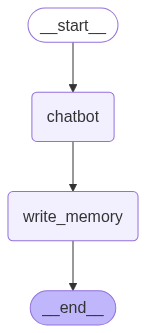

In [107]:
graph

# 測試和使用函數

In [108]:
def stream_graph_updates(graph, user_input: str, config: dict):
    """串流輸出 graph 更新"""
    try:
        for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config):
            if "chatbot" in event:
                for value in event.values():
                    print("Assistant:", value["messages"][-1].content)
    except Exception as e:
        print(f"串流處理錯誤: {e}")
        import traceback
        traceback.print_exc()

In [109]:
def test_basic_chatbot():
    """測試基本版聊天機器人"""
    print("=== 測試基本版聊天機器人（含短期記憶優化） ===")
    graph = create_basic_graph()
    config = {"configurable": {"thread_id": "conversation_1"}}

    print("開始對話 (輸入 'quit', 'exit', 'q' 停止對話)")
    while True:
        try:
            user_input = input("User: ")
            if user_input.lower() in ["quit", "exit", "q"]:
                print("Goodbye!")
                break
            stream_graph_updates(graph, user_input, config)
        except Exception as e:
            print(f"錯誤: {e}")
            break


In [110]:
def test_memory_chatbot():
    """測試包含長期記憶的聊天機器人 - 修正版"""
    print("=== 測試長期記憶聊天機器人 ===")
    graph, store = create_memory_graph()  # 接收 store

    print(f"Main Store ID: {id(store)}")
    print(f"Global Store ID: {id(global_store)}")

    # 使用者A的第一次對話
    print("\n--- 使用者A的第一次對話 ---")
    # 修正：直接將 store 加入 config
    config1 = {
        "configurable": {
            "thread_id": "conversation_1",
            "user_id": "user_a",
            "store": store  # 直接傳遞 store
        }
    }

    print("開始對話 (輸入 'quit', 'exit', 'q' 停止對話)")
    while True:
        try:
            user_input = input("User A: ")
            if user_input.lower() in ["quit", "exit", "q"]:
                print("結束第一次對話!")
                break
            stream_graph_updates(graph, user_input, config1)
        except Exception as e:
            print(f"錯誤: {e}")
            break

    # 使用者A的第二次對話（新的 thread，但同一個 user）
    print("\n--- 使用者A的第二次對話 ---")
    # 修正：創建新的 config，但使用相同的 store
    config2 = {
        "configurable": {
            "thread_id": "conversation_2",
            "user_id": "user_a",
            "store": store  # 使用相同的 store 實例
        }
    }

    print("開始第二次對話 (輸入 'quit', 'exit', 'q' 停止對話)")
    while True:
        try:
            user_input = input("User A: ")
            if user_input.lower() in ["quit", "exit", "q"]:
                print("結束第二次對話!")
                break
            stream_graph_updates(graph, user_input, config2)
        except Exception as e:
            print(f"錯誤: {e}")
            break


進階版功能

In [111]:
class UserProfile(BaseModel):
    """結構化的使用者檔案"""
    first_name: Optional[str] = None
    last_name: Optional[str] = None
    preferred_lang: List[str] = []
    interests: List[str] = []
    background: Optional[str] = None

def advanced_write_memory(state: State, *, config):
    """進階版記憶寫入，使用結構化輸出"""
    messages = state["messages"]
    user_id = config["configurable"]["user_id"]

    # 獲取 store 的邏輯與基本版保持一致
    store = None
    if hasattr(config, 'store'):
        store = config.store
    elif 'store' in config:
        store = config['store']
    elif 'store' in config.get('configurable', {}):
        store = config['configurable']['store']
    else:
        global global_store
        store = global_store

    if not store:
        return {}

    recent_messages = messages[-4:] if len(messages) >= 4 else messages

    conversation_text = ""
    for msg in recent_messages:
        if isinstance(msg, HumanMessage):
            conversation_text += f"使用者：{msg.content}\n"
        elif isinstance(msg, AIMessage):
            conversation_text += f"助手：{msg.content}\n"

    structured_llm = llm.with_structured_output(UserProfile)

    try:
        profile_prompt = f"""
        根據以下對話，提取使用者的資訊：
        {conversation_text}

        請提取：
        - first_name: 使用者的名字
        - last_name: 使用者的姓氏
        - preferred_lang: 偏好語言列表（如 ["zh-tw", "en"]）
        - interests: 興趣愛好列表
        - background: 背景資訊

        如果某些資訊不明確，請留空。
        """

        new_profile = structured_llm.invoke([SystemMessage(content=profile_prompt)])
        store.put(("user_profiles", user_id), "structured_profile", new_profile.dict())
        print(f"已儲存結構化使用者檔案: {new_profile}")

    except Exception as e:
        print(f"結構化記憶寫入錯誤: {e}")

    return {}

測試

In [114]:
print("聊天機器人記憶優化作業")
print("1. 測試基本版（短期記憶優化）")
print("2. 測試長期記憶版")
print("3. 退出")

while True:
    choice = input("\n請選擇測試項目 (1-3): ")

    if choice == "1":
        test_basic_chatbot()
    elif choice == "2":
        test_memory_chatbot()3
    elif choice == "3":
        print("再見！")
        break
    else:
        print("無效選擇，請重試")

聊天機器人記憶優化作業
1. 測試基本版（短期記憶優化）
2. 測試長期記憶版
3. 退出

請選擇測試項目 (1-3): 1
=== 測試基本版聊天機器人（含短期記憶優化） ===
開始對話 (輸入 'quit', 'exit', 'q' 停止對話)
User: 你好


Traceback (most recent call last):
  File "<ipython-input-108-3fe4c8b9022b>", line 4, in stream_graph_updates
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config):
  File "/usr/local/lib/python3.11/dist-packages/langgraph/pregel/__init__.py", line 2436, in stream
    for _ in runner.tick(
  File "<ipython-input-54-b7b75ba024bd>", line 24, in chatbot_basic
    response = llm.invoke(trimmed_messages)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/langchain_core/language_models/chat_models.py", line 371, in invoke
    "ChatGeneration",
  File "/usr/local/lib/python3.11/dist-packages/langchain_core/language_models/chat_models.py", line 956, in generate_prompt
    prompt_messages = [p.to_messages() for p in prompts]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/langchain_core/language_models/chat_models.py", line 775, in generate
    results.appe

串流處理錯誤: Error code: 429 - {'error': {'message': 'Rate limit exceeded: free-models-per-day. Add 10 credits to unlock 1000 free model requests per day', 'code': 429, 'metadata': {'headers': {'X-RateLimit-Limit': '50', 'X-RateLimit-Remaining': '0', 'X-RateLimit-Reset': '1748995200000'}, 'provider_name': None}}, 'user_id': 'user_2w9gBJLw3SzVow6vIHt7E17gtjY'}
User: q
Goodbye!

請選擇測試項目 (1-3): 
無效選擇，請重試

請選擇測試項目 (1-3): 3
再見！
